In [1]:
#https://medium.com/@vedantjumle/class-conditioned-diffusion-models-using-keras-and-tensorflow-9997fa6d958c
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env ROCM_PATH=/opt/rocm
import tensorflow as tf
tf.test.is_built_with_rocm()
# document export HSA_OVERRIDE_GFX_VERSION=10.3.0
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

from tensorflow.python.framework.ops import disable_eager_execution,enable_eager_execution
#disable_eager_execution()

env: HSA_OVERRIDE_GFX_VERSION=10.3.0
env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: ROCM_PATH=/opt/rocm


2023-03-21 09:12:22.770154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 09:12:22.824028: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 09:12:24.112926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 09:12:24.131169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] suc

In [2]:
#TODO document jupyter
import pickle
import configparser
import sqlite3 as sl
import pandas as pd
import numpy as np
from PIL import Image

configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'
p =  configParser.get('extractFacesLatents', 'dbChunk')

# TODO Better display of progress and handling of exceptions
contLoop = True # Flag to continue to get chunks of videos from database
con = sl.connect(datasetPathDatabase)
offset = 0
while(contLoop):
    data = con.execute('''SELECT F.LATENT_REP,A.SPEAKER_EMB FROM VIDEO V 
                        INNER JOIN FACE F ON V.ID = F.VIDEO_ID 
                       INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID 
                       WHERE F.LATENT_REP IS NOT NULL AND AUDIO_PRE = 1 AND FACES_PRE = 1
                        ''')
    contLoop = False
    offset = offset + int(p)
    print("Got chunk of DATA from database. Training diffusion network")
    dataGotten = data.fetchall()
    for latent_rep_pickled, speaker_emb_pickled in dataGotten:
        latent_rep = pickle.loads(latent_rep_pickled)
        speaker_emb = pickle.loads(speaker_emb_pickled)


con.close()
        
        





Got chunk of DATA from database. Training diffusion network


In [3]:
#https://towardsdatascience.com/stable-diffusion-using-hugging-face-501d8dbdd8
#https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

In [4]:
from diffusers import DDPMPipeline

/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to("cuda")

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Fetching 4 files: 100%|██████████| 4/4 [01:47<00:00, 26.94s/it]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.14.0",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [6]:
images = image_pipe().images

100%|██████████| 1000/1000 [01:08<00:00, 14.67it/s]


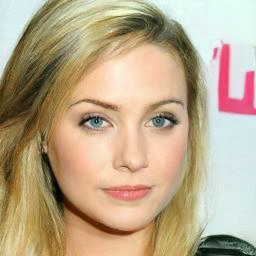

In [7]:
images[0]

In [8]:
image_pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.14.0",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [9]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

In [10]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (c

In [11]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

In [12]:
model_random = UNet2DModel(**model.config)

In [13]:
model_random.save_pretrained("my_model")

In [14]:
model_random = UNet2DModel.from_pretrained("my_model")

In [15]:
import torch

torch.manual_seed(0)

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

In [16]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

In [17]:
noisy_residual.shape

torch.Size([1, 3, 256, 256])

In [18]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)

/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [19]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('prediction_type', 'epsilon'),
            ('clip_sample_range', 1.0),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.1.1')])

In [20]:
scheduler.save_config("my_scheduler")
new_scheduler = DDPMScheduler.from_config("my_scheduler")

In [21]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=2, sample=noisy_sample
).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

In [22]:
import PIL.Image
import numpy as np

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [23]:
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

  5%|▍         | 48/1000 [00:03<01:03, 14.97it/s]

'Image at step 50'

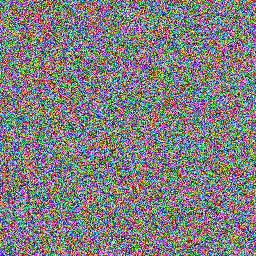

 10%|▉         | 99/1000 [00:06<01:00, 14.82it/s]

'Image at step 100'

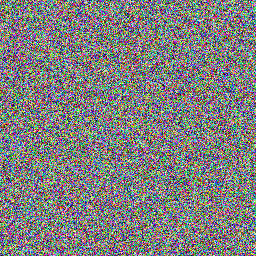

 15%|█▍        | 149/1000 [00:10<00:57, 14.82it/s]

'Image at step 150'

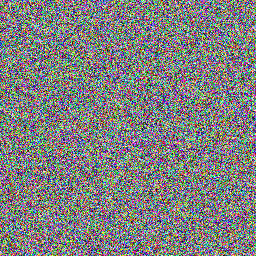

 20%|█▉        | 199/1000 [00:13<00:54, 14.81it/s]

'Image at step 200'

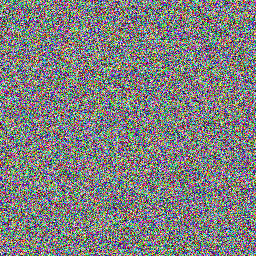

 25%|██▍       | 249/1000 [00:16<00:50, 14.73it/s]

'Image at step 250'

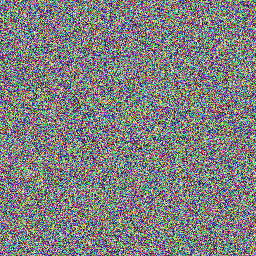

 30%|██▉       | 299/1000 [00:20<00:47, 14.83it/s]

'Image at step 300'

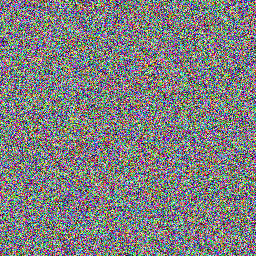

 35%|███▍      | 349/1000 [00:23<00:43, 14.80it/s]

'Image at step 350'

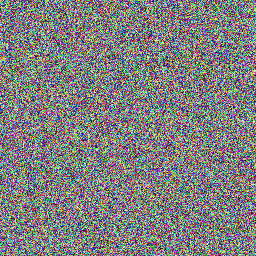

 40%|███▉      | 399/1000 [00:26<00:40, 14.84it/s]

'Image at step 400'

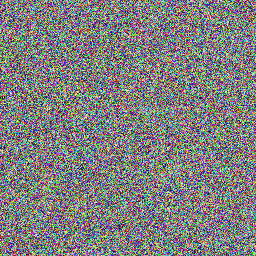

 45%|████▍     | 449/1000 [00:30<00:37, 14.70it/s]

'Image at step 450'

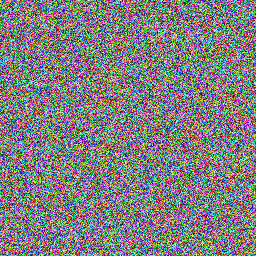

 50%|████▉     | 499/1000 [00:33<00:33, 14.82it/s]

'Image at step 500'

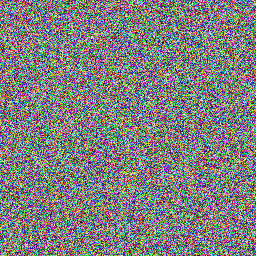

 55%|█████▍    | 549/1000 [00:37<00:30, 14.80it/s]

'Image at step 550'

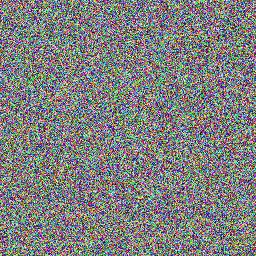

 60%|█████▉    | 599/1000 [00:40<00:27, 14.83it/s]

'Image at step 600'

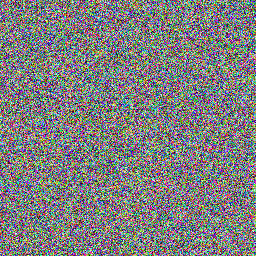

 65%|██████▍   | 649/1000 [00:43<00:23, 14.89it/s]

'Image at step 650'

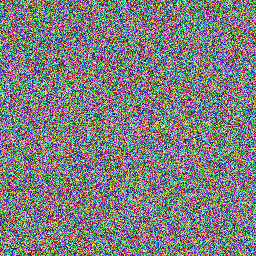

 70%|██████▉   | 699/1000 [00:47<00:20, 14.97it/s]

'Image at step 700'

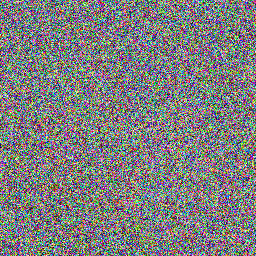

 75%|███████▍  | 749/1000 [00:50<00:16, 14.84it/s]

'Image at step 750'

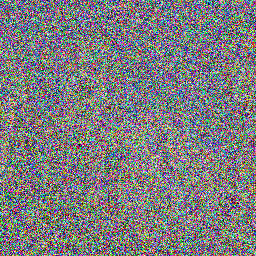

 80%|███████▉  | 799/1000 [00:53<00:13, 15.01it/s]

'Image at step 800'

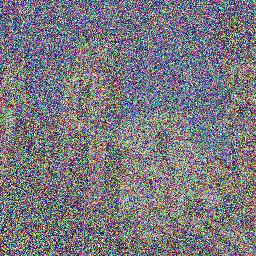

 85%|████████▍ | 849/1000 [00:57<00:10, 14.92it/s]

'Image at step 850'

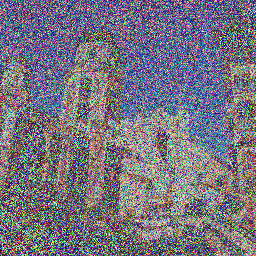

 90%|████████▉ | 899/1000 [01:00<00:06, 14.84it/s]

'Image at step 900'

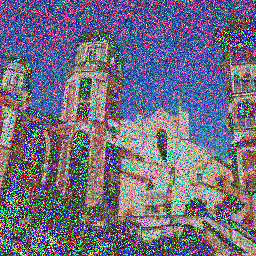

 95%|█████████▍| 949/1000 [01:04<00:03, 14.93it/s]

'Image at step 950'

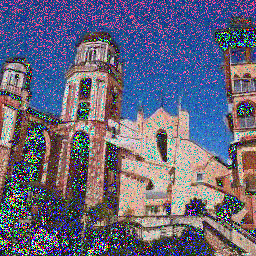

100%|█████████▉| 999/1000 [01:07<00:00, 14.95it/s]

'Image at step 1000'

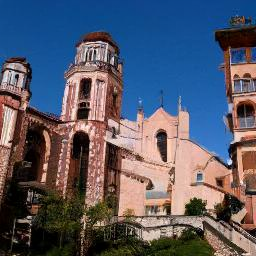

100%|██████████| 1000/1000 [01:07<00:00, 14.80it/s]


In [24]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

In [25]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_config(repo_id)

/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [26]:
scheduler.set_timesteps(num_inference_steps=50)

 18%|█▊        | 9/50 [00:00<00:02, 15.38it/s]

'Image at step 10'

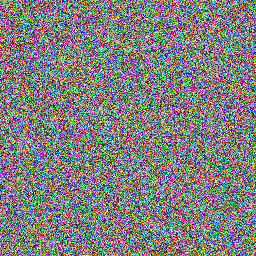

 38%|███▊      | 19/50 [00:01<00:02, 14.90it/s]

'Image at step 20'

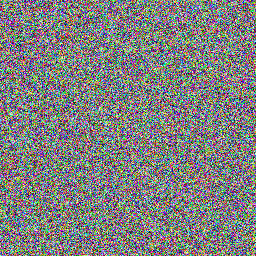

 58%|█████▊    | 29/50 [00:01<00:01, 14.80it/s]

'Image at step 30'

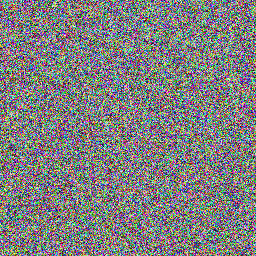

 78%|███████▊  | 39/50 [00:02<00:00, 14.77it/s]

'Image at step 40'

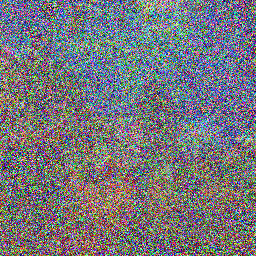

 98%|█████████▊| 49/50 [00:03<00:00, 14.66it/s]

'Image at step 50'

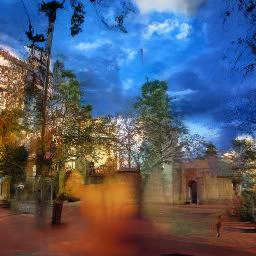

100%|██████████| 50/50 [00:03<00:00, 14.49it/s]


In [27]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t).sample

  # 2. compute previous image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample).prev_sample

  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      display_sample(sample, i + 1)

In [ ]:
#https://colab.research.google.com/gist/anton-l/f3a8206dae4125b93f05b1f5f703191d/diffusers_training_example.ipynb#scrollTo=4dnwEwhV4SrD

In [28]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-butterflies-128'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [29]:
from datasets import load_dataset

config.dataset = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset, split="train")

# Feel free to try other datasets from https://hf.co/huggan/ too! 
# Here's is a dataset of flower photos:
# config.dataset = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset, split="train")

# Or just load images from a local folder!
# config.dataset = "imagefolder"
# dataset = load_dataset(config.dataset, data_dir="path/to/folder")

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 465.26it/s]
                                                                                    

Dataset parquet downloaded and prepared to /home/gamal/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.
